In [1]:
import torch
from torch import nn, optim
import random
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from transformers import AutoModelForImageClassification, AutoImageProcessor, TrainingArguments, Trainer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import json
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR10
from PIL import Image, ImageFile
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

c:\VSCode Codes\ResAI\resai-venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.backends.cudnn.benchmark = True

In [3]:
# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the NSFW model and processor
nsfw_model = AutoModelForImageClassification.from_pretrained("perrytheplatypus/falconsai-finetuned-nsfw-detect")
processor = AutoImageProcessor.from_pretrained("perrytheplatypus/falconsai-finetuned-nsfw-detect")
nsfw_model.to(device)
torch.manual_seed(42)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
# Allow loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define the transformation to resize images to 224x224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the NSFW dataset
nsfw_dataset = load_dataset("DarkyMan/nsfw-image-classification")

# Label the NSFW images (label 1 for NSFW)
nsfw_transformed_images = []
nsfw_labels = []
for sample in nsfw_dataset["train"]:
    try:
        image = sample["image"]  # Access the image
        image = image.convert("RGB")  # Ensure the image is in RGB format
        transformed_image = transform(image)
        nsfw_transformed_images.append(transformed_image)
        nsfw_labels.append(1)  # Label NSFW images as 1
    except Exception as e:
        print(f"Error processing image: {e}")

# Load the CIFAR-10 dataset
cifar10 = CIFAR10(root='./data', train=True, download=True)

# Sample 604 images from CIFAR-10 to match the size of the NSFW dataset
num_samples = 604
sampled_cifar_images = random.sample(range(len(cifar10)), num_samples)

# Label the sampled CIFAR-10 images as SFW (label 0)
sfw_transformed_images = []
sfw_labels = []
for idx in sampled_cifar_images:
    image, _ = cifar10[idx]  # Access the image (we don't need the label)
    image = image.convert("RGB")  # Ensure the image is in RGB format
    transformed_image = transform(image)
    sfw_transformed_images.append(transformed_image)
    sfw_labels.append(0)  # Label CIFAR-10 images as 0 (SFW)

# Merge the NSFW and SFW datasets
merged_images = nsfw_transformed_images + sfw_transformed_images
merged_labels = nsfw_labels + sfw_labels

# Convert the images to tensors and create a TensorDataset
merged_images_tensor = torch.stack(merged_images)
merged_labels_tensor = torch.tensor(merged_labels)

dataset = torch.utils.data.TensorDataset(merged_images_tensor, merged_labels_tensor)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of samples in the merged dataset: {len(dataset)}")

100%|██████████| 170M/170M [00:23<00:00, 7.25MB/s] 


Number of samples in the merged dataset: 1208


In [5]:
# Define the loss function (cross-entropy loss for binary classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (AdamW is often used for transformers)
optimizer = optim.AdamW(nsfw_model.parameters(), lr=1e-5)

import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
epochs = 5  # You can adjust this as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nsfw_model.to(device)

for epoch in range(epochs):
    nsfw_model.train()  # Set the model to training mode
    running_loss = 0.0

    # Training step
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = nsfw_model(images)
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and store average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training loss for epoch {epoch+1}: {avg_train_loss:.4f}")

    # Validation step
    nsfw_model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = nsfw_model(images)
            loss = criterion(outputs.logits, labels)

            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.logits, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate and store validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    accuracy = (correct_predictions / total_predictions) * 100
    val_accuracies.append(accuracy)

    print(f"Validation loss for epoch {epoch+1}: {avg_val_loss:.4f}")
    print(f"Validation accuracy for epoch {epoch+1}: {accuracy:.2f}%")

Training loss for epoch 1: 0.0699
Validation loss for epoch 1: 0.0045
Validation accuracy for epoch 1: 100.00%


Training loss for epoch 2: 0.0034
Validation loss for epoch 2: 0.0023
Validation accuracy for epoch 2: 100.00%


Training loss for epoch 3: 0.0013
Validation loss for epoch 3: 0.0018
Validation accuracy for epoch 3: 100.00%


Training loss for epoch 4: 0.0009
Validation loss for epoch 4: 0.0015
Validation accuracy for epoch 4: 100.00%


Training loss for epoch 5: 0.0007
Validation loss for epoch 5: 0.0013
Validation accuracy for epoch 5: 100.00%


In [6]:
print(val_accuracies[0])

100.0


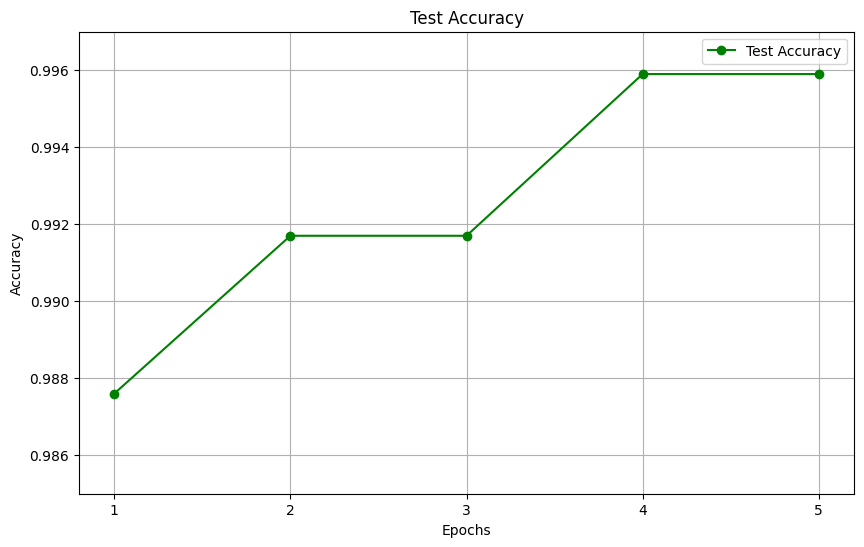

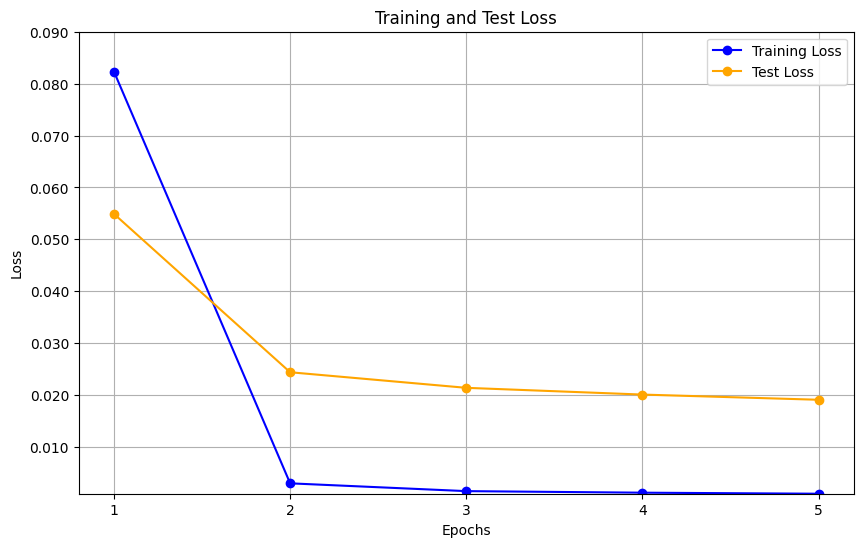

In [7]:
epochs_range = range(1, epochs + 1)

val_accuracies_test = [0.9876, 0.9917, 0.9917, 0.9959, 0.9959]

# Plot 1: Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, val_accuracies_test, label="Test Accuracy", marker='o', color='green')

plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.985, 0.997)  # Accuracy is in percentage
plt.xticks(epochs_range)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Format y-axis to 4 decimal places
plt.legend(loc="best")
plt.show()

train_loss = [0.0823, 0.0030, 0.0015, 0.0012, 0.0010]
test_loss = [0.0549, 0.0244, 0.0214, 0.0201, 0.0191]

# Plot 2: Training and Validation Losses
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_loss, label="Training Loss", marker='o', color='blue')
plt.plot(epochs_range, test_loss, label="Test Loss", marker='o', color='orange')

plt.title("Training and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0.0010, 0.09)
plt.xticks(epochs_range)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.legend(loc="best")
plt.show()

In [8]:
# Save the model and processor to the desired directory
output_dir = "./finetuned_NSFW_image_detection_ViT_model"

# Save the model's weights and configuration
nsfw_model.save_pretrained(output_dir)

# Save the processor's configuration
processor.save_pretrained(output_dir)

['./finetuned_NSFW_image_detection_ViT_model\\preprocessor_config.json']

In [9]:
import os
print(os.listdir(output_dir))

['config.json', 'model.safetensors', 'preprocessor_config.json']


In [10]:
torch.save({
    'images': merged_images_tensor,
    'labels': merged_labels_tensor
}, 'merged_nsfw_sfw_dataset.pt')

print("Dataset saved successfully!")

Dataset saved successfully!


In [11]:
import pandas as pd

# Create a DataFrame with the image paths and labels
image_paths = [f"image_{i}.jpg" for i in range(len(merged_images_tensor))]
labels = merged_labels_tensor.numpy()  # Convert tensor to numpy array

# Save as a CSV file
data = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

# Save the DataFrame to a CSV file
data.to_csv("merged_nsfw_sfw_dataset.csv", index=False)

print("Dataset saved as CSV!")

Dataset saved as CSV!


In [12]:
import pandas as pd
import torch

# Convert the tensor images and labels into numpy arrays for saving
images_numpy = torch.stack(merged_images).numpy()
labels_numpy = torch.tensor(merged_labels).numpy()

# Create a DataFrame with image data (flatten the images to 1D arrays for storage)
image_data = images_numpy.reshape(images_numpy.shape[0], -1)  # Flatten each image
df = pd.DataFrame(image_data)
df['label'] = labels_numpy

# Save the DataFrame as a Parquet file
df.to_parquet("merged_nsfw_sfw_dataset.parquet", engine="pyarrow")

print("Dataset saved as Parquet!")


c:\VSCode Codes\ResAI\resai-venv\lib\site-packages\pandas\io\parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Dataset saved as Parquet!
